## Investigating MOT, VES and VCA data

We've got a sample of 1.4 million vehicles that have been downloaded from the VES API - this is an exploration of the data. We will look for:
* how complete the data are
* any anomalies
* anything else that may need doing in the future
* whether the VCA database might be able to help us gain insights on the vehicles' emissions, etc.

In [2]:
# Import packages
import pandas_gbq
from google.oauth2 import service_account
import os
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt
import pandas as pd
from tqdm import tqdm
from datetime import date, datetime

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

### Introduction to the data
We have two MOT-derived tables:
* `mots.tests`
* `mots.vehicles`

As the names imply, we have tests, where each row is an MOT test, with details about passes, failures, odometer readings, and we have vehicles, which has some details about vehicles. 

We also have a sample of 1.4 million vehicles details that have been downloaded from the VES API. 

We've performed a join on VES API 1.4 million with `mots.vehicles`, finding the intersection. This has yielded a large table saved in `experimental_tables` called `VES_MOT_vehicles_join`. We used the following SQL query to generate this table, which takes into account the problem of reused number plates.

```
WITH join_condition as (
    SELECT registration as reg, MAX(registrationDate) as regDate
    FROM `rugged-baton-283921.mots.vehicles` 
    WHERE registration IN (SELECT registrationNumber FROM `rugged-baton-283921.mots.VES_results`)
    GROUP BY registration
),
mots_vehicles as (
    SELECT *
    FROM `rugged-baton-283921.mots.vehicles` A
    JOIN join_condition B
    ON A.registration = B.reg AND A.registrationDate = B.regDate 
) SELECT *
FROM mots_vehicles A
JOIN `rugged-baton-283921.mots.VES_results` B
ON A.registration = B.registrationNumber;``
```

In short, this query:
* creates a table with two columns,  a VRN and the latest registration date available in the database (see note below)
* finds the intersection between the two-column table created above with the `mots.vehicles` table, so that it extracts only the youngest vehicles using any particular VRN in the case of a reused plate,
* lastly, joins the results of the intersection above with the details from the VES API using VRN as the key. 

Note: we take the latest registration date because the VES API only contains the details of the latest vehicle to use a particular VRN, and indeed it only has vehicles in the database that are current (i.e. they have not been scrapped or written off). 

The result of the above SQL query gives us a table with the following schema:


Field name | Type |
---|---|
registration|STRING|
make|STRING|
model|STRING|
firstUsedDate|TIMESTAMP|
registrationDate|TIMESTAMP|
manufactureDate|TIMESTAMP|
engineSize|FLOAT|
fuelType|STRING|
primaryColour|STRING|
vehicleId|STRING|
jsonPage|STRING|
reg|STRING|
regDate|TIMESTAMP|
registrationNumber|STRING|
co2Emissions|STRING|
engineCapacity|STRING|
markedForExport|STRING|
fuelType_1|STRING|
motStatus|STRING|
colour|STRING|
make_1|STRING|
typeApproval|STRING|
yearOfManufacture|STRING|
taxDueDate|STRING|
taxStatus|STRING|
dateOfLastV5CIssued|STRING|
motExpiryDate|STRING|
wheelplan|STRING|
monthOfFirstRegistration|STRING|
revenueWeight|STRING|
monthOfFirstDvlaRegistration|STRING|
euroStatus|STRING|
realDrivingEmissions|STRING|
artEndDate|STRING|

### Pull the data into pandas

In [3]:
# Authenticate with google
project_id = 'rugged-baton-283921'
credentials = service_account.Credentials.from_service_account_file('rugged-baton-283921-5706f65c85fe.json')

# Instantiating the bigquery client
bqclient = bigquery.Client(credentials=credentials, project=project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [4]:
# We're going to leave out one or two fields, but we'll take almost everything.
sql = """
SELECT registration, make, model, registrationDate, manufactureDate, engineSize, fuelType, primaryColour, regDate, co2Emissions, engineCapacity, fuelType_1, motStatus, colour, make_1, typeApproval, yearOfManufacture, taxStatus, dateOfLastV5CIssued, motExpiryDate, wheelplan, monthOfFirstDvlaRegistration, monthOfFirstRegistration, revenueWeight, euroStatus, realDrivingEmissions
FROM `rugged-baton-283921.experimental_tables.VES_MOT_vehicles_join`
"""

In [5]:
df = (bqclient.query(sql).result().to_dataframe(bqstorage_client=bqstorageclient, progress_bar_type='tqdm'))

Downloading: 100%|███████████████████████████████████████████████████████| 1442478/1442478 [03:20<00:00, 7194.65rows/s]


A first look at the suggests all is well. "

In [6]:
df.shape

(1442478, 26)

Data types have been preserved from BigQuery, but some numeric data types are listed as 'object'.

In [7]:
df.dtypes

registration                                 object
make                                         object
model                                        object
registrationDate                datetime64[ns, UTC]
manufactureDate                 datetime64[ns, UTC]
engineSize                                  float64
fuelType                                     object
primaryColour                                object
regDate                         datetime64[ns, UTC]
co2Emissions                                 object
engineCapacity                               object
fuelType_1                                   object
motStatus                                    object
colour                                       object
make_1                                       object
typeApproval                                 object
yearOfManufacture                            object
taxStatus                                    object
dateOfLastV5CIssued                          object
motExpiryDat

In [8]:
df['co2Emissions'] = df['co2Emissions'].apply(lambda x: pd.to_numeric(x))
df['engineCapacity'] = df['engineCapacity'].apply(lambda x: pd.to_numeric(x))
df['revenueWeight'] = df['revenueWeight'].apply(lambda x: pd.to_numeric(x))

In [9]:
df.isna().sum()

registration                          0
make                                  0
model                              3646
registrationDate                      0
manufactureDate                     218
engineSize                         2286
fuelType                              0
primaryColour                         0
regDate                               0
co2Emissions                      86026
engineCapacity                      182
fuelType_1                           21
motStatus                             0
colour                                0
make_1                                0
typeApproval                     111849
yearOfManufacture                   226
taxStatus                             0
dateOfLastV5CIssued                   1
motExpiryDate                      1717
wheelplan                             0
monthOfFirstDvlaRegistration    1429596
monthOfFirstRegistration              0
revenueWeight                    938442
euroStatus                      1441597


A summary of the missing values:

`model` - this is not too many.

`manufactureDate` - might not be a problem as we have plenty of dates indicating origin/first use

`engineSize` - not many, and we might be able to do something about this. 

`co2Emissions` is missing for 86,000 records, or 6.1% of cases. That's not too bad, but maybe we'll have a look and see if we can rectify this with some classifcation problem solving. 

`engineCapacity` is missing in a tiny number of cases. 

`typeApproval` is missing in 111849 cases - that might be an interesting problem to try to solve. 

`yearofManufacture` is missing in 226 cases - I wonder how many intersect with the 218 missing `manufactureDate` records above - maybe we can use one to fill in the other?

`motExpiryDate` is missing in a few, no big deal

`monthofFirstDvlaRegistration` is missing in almost every case.

`revenueWeight`, whatever that is, is missing in most cases.

`euroStatus` is missing in almost every case.
`realDrivingEmissions` are also missing in almost every case. 

There are quite a few NaNs under model. Let's investigate those first. 

In [10]:
df[df['model'].isna()].head()

,registration,make,model,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,regDate,co2Emissions,...,yearOfManufacture,taxStatus,dateOfLastV5CIssued,motExpiryDate,wheelplan,monthOfFirstDvlaRegistration,monthOfFirstRegistration,revenueWeight,euroStatus,realDrivingEmissions
77,HP02JOY,BMW,None,2014-01-01 00:00:00+00:00,2014-01-01 00:00:00+00:00,1000.0,Petrol,White,2014-01-01 00:00:00+00:00,0.0,...,2011,Taxed,2017-09-15,2020-12-21,2 WHEEL,2015-01,2011-06,NaN,None,None
79,W139VEL,TOYOTA,None,2000-08-01 00:00:00+00:00,2000-08-01 00:00:00+00:00,2360.0,Petrol,White,2000-08-01 00:00:00+00:00,275.0,...,2000,Taxed,2017-12-19,2021-07-24,2 AXLE RIGID BODY,2007-09,2000-05,NaN,None,None
83,J170GCH,TIGER,None,2006-01-01 00:00:00+00:00,2006-01-01 00:00:00+00:00,1988.0,Petrol,Yellow,2006-01-01 00:00:00+00:00,NaN,...,1992,Taxed,2020-09-26,2021-07-06,2 AXLE RIGID BODY,2009-12,1992-03,NaN,None,None
403,RX56EZJ,FIAT,None,2006-09-06 00:00:00+00:00,2006-09-06 00:00:00+00:00,2800.0,Diesel,White,2006-09-06 00:00:00+00:00,0.0,...,2006,Taxed,2020-08-28,2021-02-21,2 AXLE RIGID BODY,None,2006-09,3500.0,None,None
430,RK51MLZ,NISSAN,None,2001-09-21 00:00:00+00:00,2001-09-21 00:00:00+00:00,2407.0,Diesel,Black,2001-09-21 00:00:00+00:00,NaN,...,2001,Taxed,2015-06-10,2021-06-17,2 AXLE RIGID BODY,None,2001-09,NaN,None,None


From a manual inspection, we have some genuinely missing models in both VES and MOT databases. 

### Observation 1: best way to determine origin date of a vehicle...
The first row of the above snippet caught my attention. HP02JOY, our un-modelled BMW, has something curious about it. `registrationDate` is 2014, as is `manufactureDate`, whereas `yearOfManufacture`, and `monthOfFirstDvlaRegistration` and `monthOfFirstRegistation` are all 2011. 

*What's the right date?*

If we use the government's vehicle enquiry website, we see that it started having MOTs in 2014, so 2011 seems like the right date. 

In [11]:
df[['registrationDate', 'manufactureDate', 'regDate', 'yearOfManufacture', 'monthOfFirstDvlaRegistration', 'monthOfFirstRegistration']].isna().sum()

registrationDate                      0
manufactureDate                     218
regDate                               0
yearOfManufacture                   226
monthOfFirstDvlaRegistration    1429596
monthOfFirstRegistration              0
dtype: int64

Looks like **`monthOfFirstRegistration`** is our more reliable indicator of the origin date of a vehicle. 

But it's a string - let's make it a datetime object. 

In [12]:
df['monthOfFirstRegistration'] = df['monthOfFirstRegistration'].apply(lambda x: datetime.strptime(x, '%Y-%m'))

In [13]:
df['monthOfFirstRegistration'].dtypes

dtype('<M8[ns]')

Let's have a look at how old our cars are:

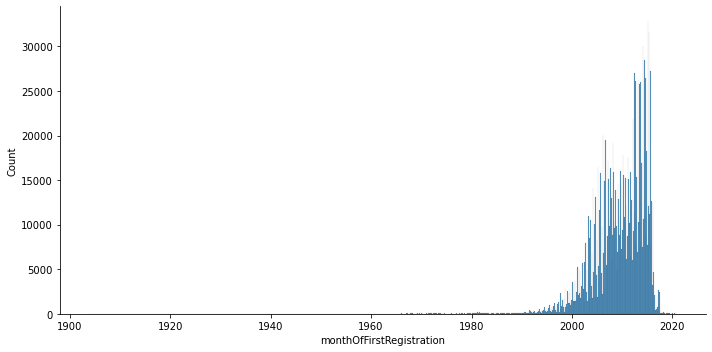

In [14]:
ax = sns.displot(data=df, x='monthOfFirstRegistration', aspect=2, height=5)
# plt.figure(dpi=300)
plt.savefig('dis_firstreg.png')

It looks like we have some pretty crazy `monthOfFirstRegistration`s - let's have a look.

In [15]:
df[df['monthOfFirstRegistration'] < '1960-01-01'].sort_values('monthOfFirstRegistration').head(5)

,registration,make,model,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,regDate,co2Emissions,...,yearOfManufacture,taxStatus,dateOfLastV5CIssued,motExpiryDate,wheelplan,monthOfFirstDvlaRegistration,monthOfFirstRegistration,revenueWeight,euroStatus,realDrivingEmissions
18367,AP221,DAIMLER,14HP,1903-12-30 00:00:00+00:00,1903-12-30 00:00:00+00:00,1701.0,Petrol,Green,1903-12-30 00:00:00+00:00,NaN,...,1903,Taxed,2016-03-16,2021-10-31,2 AXLE RIGID BODY,None,1903-12-01,NaN,None,None
151326,F815AFX,SUZUKI,TS125,1989-03-01 00:00:00+00:00,1989-03-01 00:00:00+00:00,124.0,Petrol,Blue,1989-03-01 00:00:00+00:00,0.0,...,1989,Taxed,2017-09-02,2020-10-13,2 WHEEL,2012-11,1919-03-01,NaN,None,None
42875,SRR344F,LAMBRETTA,SX,1919-12-31 00:00:00+00:00,1968-12-31 00:00:00+00:00,198.0,Petrol,White,1919-12-31 00:00:00+00:00,0.0,...,1968,Taxed,2013-02-21,2020-11-24,2 WHEEL,None,1919-12-01,NaN,None,None
32766,W252GAG,KAWASAKI,ZX-9R,2000-05-19 00:00:00+00:00,2000-05-19 00:00:00+00:00,899.0,Petrol,Green,2000-05-19 00:00:00+00:00,0.0,...,2000,Taxed,2017-09-06,2020-09-13,2 WHEEL,2015-06,1920-05-01,NaN,None,None
226895,XP9083,BENTLEY,None,1923-12-16 00:00:00+00:00,1971-01-01 00:00:00+00:00,5295.0,Petrol,Green,1923-12-16 00:00:00+00:00,NaN,...,1923,Taxed,2014-01-16,2021-08-04,2 AXLE RIGID BODY,None,1923-12-01,NaN,None,None


That Suzuki TS125, reg F815AFX is definitely not from 1919. `monthOfFirstRegistration` is not without its flaws, then. 

#### Add vehicle age

We'll use `monthOfFirstRegistration` to do this, since it seems the best column to do it.

In [16]:
df.columns.to_list()[23]

'revenueWeight'

In [17]:
today = date.today()
df['age'] = df.iloc[:, 23].apply(lambda x: today.year - x.year)

AttributeError: 'float' object has no attribute 'year'

#### Filter by age
We're really only interested in vehicles from the last decade or two. Let's just remove the historical stuff, nice though it is.

In [ ]:
df = df[df['monthOfFirstRegistration'] > '2000-01-01']

In [ ]:
df.dtypes

In [ ]:
sns.pairplot(df[['engineSize', 'co2Emissions', 'engineCapacity', 'monthOfFirstRegistration', 'age']])
plt.savefig('exploring_ves_mot.png')

### Exploring the differences between fuelType columns in VES, MOT (and VCA)

Two fuelType columns:
* `fuelType` - from VES
* `fuelType_1`- from MOT

In [ ]:
# Let's give them clearer names
df.rename(columns={'fuelType_1': 'vesft', 'fuelType': 'motft'}, inplace=True)

In [ ]:
# And we'll reorder the columns to make it a bit easier to read the values
df.columns.to_list()

In [ ]:
df = df[['registration',
 'make',
 'model',
 'motft',
 'vesft',
 'registrationDate',
 'manufactureDate',
 'engineSize',
 'primaryColour',
 'vehicleID',
 'regDate',
 'co2Emissions',
 'engineCapacity',
 'motStatus',
 'colour',
 'make_1',
 'typeApproval',
 'yearOfManufacture',
 'taxStatus',
 'dateOfLastV5CIssued',
 'motExpiryDate',
 'wheelplan',
 'monthOfFirstDvlaRegistration',
 'monthOfFirstRegistration',
 'revenueWeight',
 'euroStatus',
 'realDrivingEmissions',
 'age']]

In [ ]:
df['vesft'] = df['vesft'].apply(lambda x: str(x).lower()) #lower cases make for easier matching
df.vesft.unique()

In [ ]:
df['motft'] = df['motft'].apply(lambda x: str(x).lower()) #lower cases make for easier matching
df.motft.unique()

So we know that there are two different sets of values. Some are obvious matches, some less so:

`vesft` | `motft`
---|---
diesel | diesel
petrol | petrol
electricity | electric
electric diesel | electric diesel
hybrid electric | hybrid electric (clean)

In [ ]:
# Let's change "electricity" to "electric"

In [ ]:
df['vesft'] = df['vesft'].apply(lambda x: x.replace('electricity', 'electric'))
df['motft'] = df['motft'].apply(lambda x: x.replace('hybrid electric (clean)', 'hybrid electric'))

Investigating which fuel type is a better indication...

We'll start by looking at 

`motft` = cng



`motft` = cng and `vesft` = hybrid seems to return only hybrids.

In [ ]:
def cleaner(row):
    if (row['vesft'] == 'hybrid electric') & (row['motft'] == 'cng'):
        row['motft'] = 'hybrid electric'
        return row
    elif (row['vesft'] == 'diesel') & (row['motft'] == 'cng'):
        row['motft'] = 'diesel'
        return row
    elif (row['vesft'] == 'gas bi-fuel') & (row['motft'] == 'cng'):
        row['vesft'] = 'cng'
        return row
    elif (row['vesft'] == 'petrol') & (row['motft'] == 'cng'):
        row['motft'] = 'petrol'
        return row
    elif (row['vesft'] == 'electric') & (row['motft'] == 'diesel'):
        row['vesft'] = 'hybrid electric'
        row['motft'] = 'hybrid electric'
        return row
    elif (row['vesft'] == 'electric diesel') & (row['motft'] == 'diesel'):
        row['vesft'] = 'hybrid electric'
        row['motft'] = 'hybrid electric'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'gas'):
        row['vesft'] = 'diesel'
        row['motft'] = 'diesel'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'gas bi-fuel'):
        row['vesft'] = 'diesel'
        row['motft'] = 'diesel'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'hybrid electric'):
        row['vesft'] = 'diesel'
        row['motft'] = 'diesel'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'none'):
        row['vesft'] = 'diesel'
        row['motft'] = 'diesel'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'other'):
        row['vesft'] = 'diesel'
        row['motft'] = 'diesel'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'hybrid electric'):
        row['vesft'] = 'diesel'
        row['motft'] = 'diesel'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'petrol'):
        row['vesft'] = 'petrol'
        row['motft'] = 'petrol'
        return row
    elif (row['motft'] == 'diesel') & (row['vesft'] == 'petrol/gas'):
        row['vesft'] = 'petrol'
        row['motft'] = 'petrol'
        return row
    else:
        return row
    

In [ ]:
df = df.apply(lambda row: cleaner(row), axis=1)

In [ ]:
df[['motft', 'vesft', 'registration']].groupby(['motft', 'vesft']).count().head(20)

In [ ]:
df[(df['motft'] == 'electric') & (df['vesft'] == 'diesel')]

In [189]:
# df['motft'].mask(df['make'] == 'TOYOTA', 'hybrid electric', inplace=True)

In [343]:
non_matches = df[df['make'] != df['make_1']]

In [344]:
print("There are {:%} of entries where the two fuel types do not match".format(len(non_matches)/len(df)))

There are 0.773385% of entries where the two fuel types do not match


In [345]:
non_matches[['vesft', 'motft']].groupby('vesft').count()

,motft
vesft,
diesel,3254
electric,24
electric diesel,23
gas,27
gas bi-fuel,913
gas diesel,1
hybrid electric,4048
none,21
other,17


In [346]:
non_matches[non_matches['vesft'] == 'electric'].head(50)

,registration,make,model,motft,vesft,registrationDate,manufactureDate,engineSize,primaryColour,vehicleID,...,taxStatus,dateOfLastV5CIssued,motExpiryDate,wheelplan,monthOfFirstDvlaRegistration,monthOfFirstRegistration,revenueWeight,euroStatus,realDrivingEmissions,age
38074,MO51CMT,ALFA ROMEO,159,petrol,electric,2010-11-30 00:00:00+00:00,2010-11-30 00:00:00+00:00,1796.0,Grey,xzZtaVV4xCgLTEyaA0FF_A==,...,Taxed,2020-09-25,None,2 AXLE RIGID BODY,None,2020-09-01,NaN,None,,1
64838,BP14WRC,MITSUBISHI,OUTLANDER,hybrid electric,electric,2014-08-01 00:00:00+00:00,2014-08-01 00:00:00+00:00,1998.0,Blue,wqj3UbdYdqySMLGKAvZhzA==,...,Taxed,2017-05-15,2021-07-27,2 AXLE RIGID BODY,None,2014-08-01,NaN,None,None,7
66240,YC64DVP,MITSUBISHI,OUTLANDER,hybrid electric,electric,2014-11-07 00:00:00+00:00,2014-11-07 00:00:00+00:00,1998.0,Black,lM9pl6oUbDJby8RGdi037A==,...,Taxed,2018-02-12,2020-11-15,2 AXLE RIGID BODY,None,2014-11-01,NaN,None,None,7
74761,XIL5622,PEUGEOT,1007,petrol,electric,2005-09-28 00:00:00+00:00,2005-09-28 00:00:00+00:00,1360.0,Blue,fQ_oPPr2D9QdZw1p6-TMZQ==,...,Taxed,2020-09-21,None,2 AXLE RIGID BODY,None,2020-09-01,1595.0,None,,1
111212,PJL100,MINI,COOPER S AUTO,petrol,electric,2013-03-30 00:00:00+00:00,2013-03-30 00:00:00+00:00,1598.0,Blue,9hxdEcpvLOkj4DAH7xJ1OA==,...,Taxed,2020-10-16,None,2 AXLE RIGID BODY,None,2020-10-01,NaN,None,,1
152012,BL13UFM,NISSAN,LEAF,hybrid electric,electric,2013-07-26 00:00:00+00:00,2013-07-26 00:00:00+00:00,1571.0,White,H3_VS6GaaBHQtxoiucDnIA==,...,Taxed,2020-06-12,2021-01-25,2 AXLE RIGID BODY,None,2013-07-01,NaN,None,None,8
175595,AHN1,PEUGEOT,107,petrol,electric,2014-07-30 00:00:00+00:00,2014-07-30 00:00:00+00:00,998.0,Blue,_cwzxd_qzWymTTjuqFdwpQ==,...,Taxed,2020-08-28,None,2 AXLE RIGID BODY,None,2020-07-01,NaN,None,,1
179098,BK14EVP,BMW,I3,hybrid electric,electric,2014-03-24 00:00:00+00:00,2014-03-24 00:00:00+00:00,657.0,Orange,pC4p6A6RbCccfYgRFM-xsw==,...,Taxed,2017-04-06,2021-03-23,2 AXLE RIGID BODY,None,2014-03-01,NaN,None,None,7
212242,K400DSS,MITSUBISHI,OUTLANDER,hybrid electric,electric,2014-11-24 00:00:00+00:00,2014-11-24 00:00:00+00:00,1998.0,White,n2wGdVnOgOfL386gLcFRYA==,...,Taxed,2020-06-08,2021-04-16,2 AXLE RIGID BODY,None,2014-11-01,NaN,None,None,7
212243,K400DSS,MITSUBISHI,OUTLANDER,hybrid electric,electric,2014-11-24 00:00:00+00:00,2014-11-24 00:00:00+00:00,1998.0,White,n2wGdVnOgOfL386gLcFRYA==,...,Taxed,2020-06-08,2021-04-16,2 AXLE RIGID BODY,None,2014-11-01,NaN,None,None,7


In [1]:
non_matches[non_matches['registration']== 'MO51CMT']

NameError: name 'non_matches' is not defined

In [347]:
df_matches = df[df['vesft'] == df['motft']]

In [348]:
df_matches.groupby(['vesft', 'motft']).size()

vesft            motft          
cng              cng                     1
diesel           diesel             629947
electric         electric             1315
electric diesel  electric diesel       379
gas              gas                     1
gas bi-fuel      gas bi-fuel            35
hybrid electric  hybrid electric     10564
petrol           petrol             729944
dtype: int64

In [349]:
df_matches[df_matches['vesft'] == 'electric']

,registration,make,model,motft,vesft,registrationDate,manufactureDate,engineSize,primaryColour,vehicleID,...,taxStatus,dateOfLastV5CIssued,motExpiryDate,wheelplan,monthOfFirstDvlaRegistration,monthOfFirstRegistration,revenueWeight,euroStatus,realDrivingEmissions,age
164,WX59HVW,MITSUBISHI,I-MIEV,electric,electric,2009-12-09 00:00:00+00:00,2009-12-09 00:00:00+00:00,NaN,White,JI32A4h2CTEcFMXduYWR-g==,...,Taxed,2020-01-09,2021-01-11,2 AXLE RIGID BODY,None,2009-12-01,NaN,None,None,12
685,AY64RPO,MITSUBISHI,OUTLANDER,electric,electric,2014-09-12 00:00:00+00:00,2014-09-12 00:00:00+00:00,NaN,Grey,F_v2s6lUtNrjiwIsR8JF0g==,...,Taxed,2016-04-06,2021-09-11,2 AXLE RIGID BODY,None,2014-09-01,NaN,None,None,7
1740,S23DPR,NISSAN,LEAF,electric,electric,2016-03-01 00:00:00+00:00,2016-03-01 00:00:00+00:00,NaN,Black,n4Atgp4yX479vLt2_ETl8g==,...,Taxed,2016-09-19,2021-02-28,2 AXLE RIGID BODY,None,2016-03-01,NaN,None,None,5
1917,YP13RZW,NISSAN,LEAF,electric,electric,2013-05-30 00:00:00+00:00,2013-05-30 00:00:00+00:00,NaN,White,l27xHmMRimeT7u-BdmsJqw==,...,Taxed,2019-04-29,2021-04-23,2 AXLE RIGID BODY,None,2013-05-01,NaN,None,None,8
2317,LG64ZVT,BMW,I3,electric,electric,2014-10-28 00:00:00+00:00,2014-10-28 00:00:00+00:00,NaN,Grey,47VBZob64s9Nj9iOpXdNnw==,...,Taxed,2018-11-09,2020-11-06,2 AXLE RIGID BODY,None,2014-10-01,NaN,None,None,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424470,DY14WCC,NISSAN,LEAF,electric,electric,2014-03-25 00:00:00+00:00,2014-03-25 00:00:00+00:00,NaN,White,xvK5qyA2kkNW6DrV-Sfzpg==,...,Taxed,2017-11-06,2021-03-24,2 AXLE RIGID BODY,None,2014-03-01,NaN,None,None,7
424547,PG04CMG,RENAULT,ZOE,electric,electric,2014-06-30 00:00:00+00:00,2014-06-30 00:00:00+00:00,NaN,White,aW0aiyCz8w3TWYW4BEOB0w==,...,Taxed,2019-08-06,2021-10-11,2 AXLE RIGID BODY,None,2014-06-01,1943.0,None,None,7
425391,BC15ZNJ,NISSAN,NV200,electric,electric,2015-08-14 00:00:00+00:00,2015-08-14 00:00:00+00:00,NaN,Blue,1nxpq2f8aKNfGh0PQodhwg==,...,SORN,2015-08-14,2021-04-14,2 AXLE RIGID BODY,None,2015-08-01,2220.0,None,None,6
425533,SM11SNV,NISSAN,LEAF,electric,electric,2011-06-29 00:00:00+00:00,2011-06-29 00:00:00+00:00,NaN,Silver,pVmzs5DpC5Hzc7ZRPTFTFQ==,...,Taxed,2014-05-13,2021-09-01,2 AXLE RIGID BODY,None,2011-06-01,NaN,None,None,10


#### We will just drop the non fueltype matches and move on. It's less than 1% of the data.

In [214]:
df = df_matches.copy()

### Perhaps we need some more data. 

Let's now try to pull in some VCA data.

In [171]:
vca_16 = pd.read_csv('https://carfueldata.vehicle-certification-agency.gov.uk/additional/aug2016/download-data-for-Aug-2016-Euro-6.zip', encoding='cp1252')

In [172]:
vca_16.head()

,Manufacturer,Model,Description,Transmission,Engine Capacity,Fuel Type,Electric energy consumption Miles/kWh,wh/km,Maximum range (Km),Maximum range (Miles),...,Fuel Cost 12000 Miles,Electricity cost,Total cost / 12000 miles,Euro Standard,Noise Level dB(A),Emissions CO [mg/km],THC Emissions [mg/km],Emissions NOx [mg/km],THC + NOx Emissions [mg/km],Particulates [No.] [mg/km]
0,ABARTH,"500, 2012 onwards",Abarth 595 and 595C 140 bhp - 11/2014 on,M5,1368.0,Petrol,NaN,NaN,NaN,NaN,...,"£1,170",NaN,"£1,170",6,72.5,455.0,23.0,9.0,NaN,NaN
1,ABARTH,"500, 2012 onwards",Abarth 595 and 595C 140 bhp - 11/2014 on,SAT5,1368.0,Petrol,NaN,NaN,NaN,NaN,...,"£1,131",NaN,"£1,131",6,73.0,445.0,25.0,22.0,NaN,NaN
2,ABARTH,"500, 2012 onwards",Abarth 595 and 595C 160 bhp - 11/2014 on,M5,1368.0,Petrol,NaN,NaN,NaN,NaN,...,"£1,170",NaN,"£1,170",6,74.0,222.0,35.0,19.0,NaN,NaN
3,ABARTH,"500, 2012 onwards",Abarth 595 and 595C 160 bhp - 11/2014 on,SAT5,1368.0,Petrol,NaN,NaN,NaN,NaN,...,"£1,131",NaN,"£1,131",6,73.5,439.0,34.0,37.0,NaN,NaN
4,ABARTH,"500, 2012 onwards",Abarth 595 and 595C 180 bhp,M5,1368.0,Petrol,NaN,NaN,NaN,NaN,...,"£1,170",NaN,"£1,170",6,71.5,498.0,36.0,27.0,NaN,NaN


In [173]:
vca_16.columns

Index(['Manufacturer', 'Model', 'Description', 'Transmission',
       'Engine Capacity', 'Fuel Type', 'Electric energy consumption Miles/kWh',
       'wh/km', 'Maximum range (Km)', 'Maximum range (Miles)',
       'Metric Urban (Cold)', 'Metric Extra-Urban', 'Metric Combined',
       'Imperial Urban (Cold)', 'Imperial Extra-Urban', 'Imperial Combined',
       'CO2 g/km', 'Fuel Cost 12000 Miles', 'Electricity cost',
       'Total cost / 12000 miles', 'Euro Standard', 'Noise Level dB(A)',
       'Emissions CO [mg/km]', 'THC Emissions [mg/km]',
       'Emissions NOx [mg/km]', 'THC + NOx Emissions [mg/km]',
       'Particulates [No.] [mg/km]'],
      dtype='object')

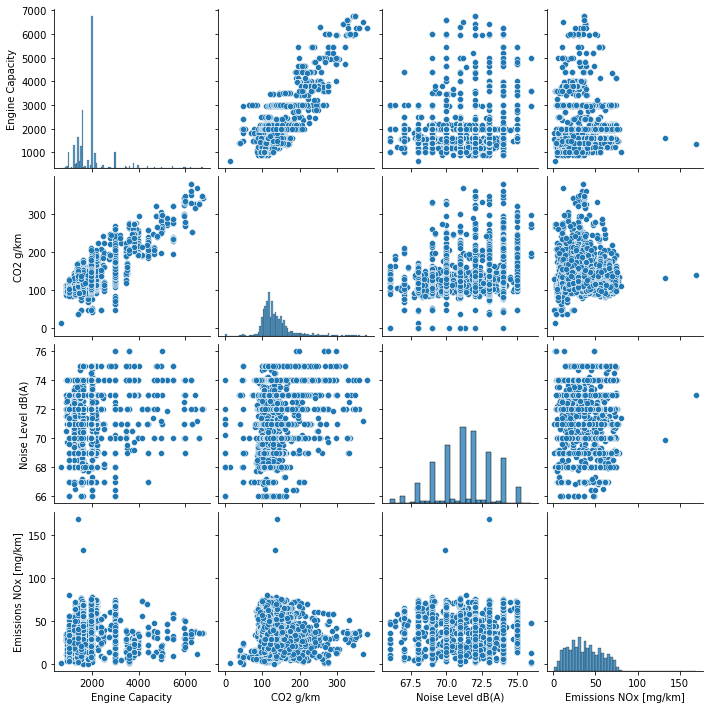

In [174]:
sns.pairplot(vca_16[['Engine Capacity', 'CO2 g/km', 'Noise Level dB(A)', 'Emissions NOx [mg/km]']])
plt.savefig('vca_explore.png')

Ok, that's enough messing around, let's try to do some matching. 

`vca_16` contains the types that were approved in 2016. So we know that no matches will have been manufactured before 2016. But since we do not have a reliable estimate of when a vehicle was manufactured, it might be difficult to match.

In [175]:
vca_16.dtypes

Manufacturer                              object
Model                                     object
Description                               object
Transmission                              object
Engine Capacity                          float64
Fuel Type                                 object
Electric energy consumption Miles/kWh    float64
wh/km                                    float64
Maximum range (Km)                       float64
Maximum range (Miles)                    float64
Metric Urban (Cold)                      float64
Metric Extra-Urban                       float64
Metric Combined                          float64
Imperial Urban (Cold)                    float64
Imperial Extra-Urban                     float64
Imperial Combined                        float64
CO2 g/km                                   int64
Fuel Cost 12000 Miles                     object
Electricity cost                          object
Total cost / 12000 miles                  object
Euro Standard       

Before matching on manufacturer, let's make it all lowercase, so we don't run into case problems.

One initial comment - why is Volkswagen in there twice??

In [176]:
vca_16['Manufacturer'] = vca_16['Manufacturer'].str.lower()
df['make'] = df['make'].str.lower()

In [177]:
rows, columns = df[df['make'].isin(vca_16.Manufacturer.unique())].shape
print('We can match on make = manufacturer in {:%} of cases.'.format(rows/len(df)))

We can match on make = manufacturer in 93.862437% of cases.


In [178]:
vca_16['Model'] = vca_16['Model'].str.lower()
df['model'] = df['model'].str.lower()

In [179]:
rows, columns = df[df['model'].isin(vca_16['Model'].unique())].shape
print('We can match on model = model in {:%} of cases.'.format(rows/len(df)))

We can match on model = model in 14.450966% of cases.


In [28]:
rows, columns = df[df['engineCapacity'].isin(vca_16['Engine Capacity'].unique())].shape
print('We can match on engineCapacity = Engine Capacity in {:%} of cases.'.format(rows/len(df)))

We can match on engineCapacity = Engine Capacity in 70.126685% of cases.


Let's try matching on engine capacity and make, and see where we go.

In [29]:
print(df['make'].value_counts().head(5))
print(vca_16['Manufacturer'].value_counts().head(5))

ford          197439
vauxhall      148048
volkswagen    133615
bmw            74921
peugeot        70655
Name: make, dtype: int64
bmw              608
audi             514
mercedes-benz    438
ford             362
volkswagen       342
Name: Manufacturer, dtype: int64


Let's give Fords a try. 197,000 in the database, and 362 categories in the VCA database. 